In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from torch_geometric.nn import HANConv
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import StandardScaler


In [7]:
hetero_data = torch.load('data/graph_biobert_hetero.pt')
print(hetero_data)

HeteroData(
  PCG={ x=[1717, 768] },
  lncRNA={ x=[1333, 768] },
  miRNA={ x=[512, 768] },
  TF={ x=[336, 768] },
  circRNA={ x=[7, 768] },
  snoRNA={ x=[3, 768] },
  (lncRNA, regulates, miRNA)={
    edge_index=[2, 1088],
    edge_attr=[1088, 13],
  },
  (lncRNA, regulates, PCG)={
    edge_index=[2, 5029],
    edge_attr=[5029, 13],
  },
  (lncRNA, regulates, TF)={
    edge_index=[2, 1570],
    edge_attr=[1570, 13],
  },
  (PCG, regulates, miRNA)={
    edge_index=[2, 11],
    edge_attr=[11, 13],
  },
  (TF, regulates, lncRNA)={
    edge_index=[2, 303],
    edge_attr=[303, 13],
  },
  (lncRNA, regulates, lncRNA)={
    edge_index=[2, 34],
    edge_attr=[34, 13],
  },
  (miRNA, regulates, lncRNA)={
    edge_index=[2, 82],
    edge_attr=[82, 13],
  },
  (PCG, regulates, PCG)={
    edge_index=[2, 36],
    edge_attr=[36, 13],
  },
  (circRNA, regulates, miRNA)={
    edge_index=[2, 3],
    edge_attr=[3, 13],
  },
  (circRNA, regulates, PCG)={
    edge_index=[2, 9],
    edge_attr=[9, 13],
  },


In [9]:
def prepare_data(data):
    # Normalize node features
    for node_type in data.node_types:
        scaler = StandardScaler()
        data[node_type].x = torch.tensor(
            scaler.fit_transform(data[node_type].x.numpy()),
            dtype=torch.float32
        )
    
    # Normalize edge attributes
    for edge_type in data.edge_types:
        if hasattr(data[edge_type], 'edge_attr'):
            scaler = StandardScaler()
            data[edge_type].edge_attr = torch.tensor(
                scaler.fit_transform(data[edge_type].edge_attr.numpy()),
                dtype=torch.float32
            )
    
    return data

hetero_data = prepare_data(hetero_data)

In [10]:
class EnhancedHAN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 num_heads, metadata, dropout=0.4):
        super().__init__()
        
        # Edge attribute transformation layers
        self.edge_transform = nn.ModuleDict()
        for edge_type in metadata[1]:
            self.edge_transform[str(edge_type)] = nn.Sequential(
                nn.Linear(13, hidden_channels),
                nn.LeakyReLU(),
                nn.Dropout(dropout)
            )
        
        # First HAN layer
        self.han_conv1 = HANConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            heads=num_heads,
            metadata=metadata,
            dropout=dropout
        )
        
        # Second HAN layer
        self.han_conv2 = HANConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            heads=num_heads,
            metadata=metadata,
            dropout=dropout
        )
        
        # Attention-based edge feature incorporation
        self.edge_attention = nn.ModuleDict()
        for edge_type in metadata[1]:
            self.edge_attention[str(edge_type)] = nn.Sequential(
                nn.Linear(hidden_channels * 2, 1),
                nn.LeakyReLU()
            )
        
        # Layer normalization
        self.layernorm = nn.LayerNorm(out_channels)
    
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Transform edge attributes
        transformed_edge_attr_dict = {}
        for edge_type, edge_attr in edge_attr_dict.items():
            transformed_edge_attr_dict[edge_type] = self.edge_transform[str(edge_type)](edge_attr)
        
        # First HAN layer
        x_dict = self.han_conv1(x_dict, edge_index_dict)
        x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        
        # Enhanced message passing with edge attributes
        for edge_type in edge_index_dict:
            src, _, dst = edge_type
            edge_index = edge_index_dict[edge_type]
            edge_attr = transformed_edge_attr_dict[edge_type]
            
            # Get source and destination node features
            src_feat = x_dict[src][edge_index[0]]
            dst_feat = x_dict[dst][edge_index[1]]
            
            # Compute attention scores
            alpha = self.edge_attention[str(edge_type)](
                torch.cat([src_feat, edge_attr], dim=-1))
            alpha = torch.sigmoid(alpha)
            
            # Update destination node features
            message = alpha * (src_feat + edge_attr)
            x_dict[dst] = x_dict[dst].scatter_add(
                0, 
                edge_index[1].unsqueeze(-1).expand_as(message),
                message
            )
        
        # Second HAN layer
        x_dict = self.han_conv2(x_dict, edge_index_dict)
        x_dict = {key: self.layernorm(x) for key, x in x_dict.items()}
        
        return x_dict

In [11]:
# Define metadata
metadata = (
    ['PCG', 'lncRNA', 'miRNA', 'TF', 'circRNA', 'snoRNA'],
    list(hetero_data.edge_types)  
)

# Initialize model
model = EnhancedHAN(
    in_channels=768,  # Input feature dimension
    hidden_channels=512,
    out_channels=256,  # Final embedding dimension
    num_heads=8,
    metadata=metadata,
    dropout=0.3
)

# Prepare edge attribute dictionary
edge_attr_dict = {
    edge_type: hetero_data[edge_type].edge_attr
    for edge_type in hetero_data.edge_types
    if hasattr(hetero_data[edge_type], 'edge_attr')
}

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Training loop
def train(model, data, epochs=100):
    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        embeddings = model(
            x_dict={node_type: data[node_type].x for node_type in data.node_types},
            edge_index_dict=data.edge_index_dict,
            edge_attr_dict=edge_attr_dict
        )
        # simple reconstruction loss
        loss = 0.0
        
        # Compute reconstruction loss for each node type
        for node_type in data.node_types:
            # Simple reconstruction loss (can be replaced with task specific loss)
            loss += F.mse_loss(embeddings[node_type], data[node_type].x[:, :256])
        
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    return embeddings

# Run training
final_embeddings = train(model, hetero_data, epochs=100)

Epoch 0, Loss: 9.9892
Epoch 10, Loss: 6.7754
Epoch 20, Loss: 6.4174
Epoch 30, Loss: 6.2769
Epoch 40, Loss: 6.4000
Epoch 50, Loss: 6.2505
Epoch 60, Loss: 6.3257
Epoch 70, Loss: 6.3375
Epoch 80, Loss: 6.2732
Epoch 90, Loss: 6.4688


In [23]:
print(final_embeddings)

{'PCG': tensor([[ 0.0228,  0.0107,  0.0045,  ..., -0.0050, -0.0221,  0.0149],
        [ 0.0227,  0.0107,  0.0045,  ..., -0.0049, -0.0220,  0.0149],
        [ 0.0196,  0.0076,  0.0014,  ..., -0.0078, -0.0118,  0.0118],
        ...,
        [ 0.0228,  0.0107,  0.0045,  ..., -0.0050, -0.0221,  0.0149],
        [ 0.0224,  0.0104,  0.0042,  ..., -0.0053, -0.0224,  0.0146],
        [ 0.0127,  0.0007, -0.0055,  ..., -0.0150, -0.0320,  0.0050]],
       grad_fn=<NativeLayerNormBackward0>), 'lncRNA': tensor([[-0.5932, -0.6034, -0.6115,  ..., -0.6202,  1.5815,  2.3060],
        [-0.4985,  1.6433,  0.9590,  ..., -0.3775, -0.4218, -0.5030],
        [-0.4581,  1.1050,  2.1418,  ..., -0.4852,  1.0341,  2.6009],
        ...,
        [ 0.0228,  0.0107,  0.0045,  ..., -0.0050, -0.0221,  0.0149],
        [ 0.0228,  0.0107,  0.0045,  ..., -0.0050, -0.0221,  0.0149],
        [ 0.0228,  0.0107,  0.0045,  ..., -0.0050, -0.0221,  0.0149]],
       grad_fn=<NativeLayerNormBackward0>), 'miRNA': tensor([[ 0.0228,

In [24]:
import os
import torch

save_dir = "HANembeddings"
os.makedirs(save_dir, exist_ok=True)

for node_type, emb in final_embeddings.items():
    torch.save(emb.cpu(), os.path.join(save_dir, f"{node_type}_embedding.pt"))
    print(f"Saved: {node_type}_embedding.pt, shape = {emb.shape}")


Saved: PCG_embedding.pt, shape = torch.Size([1717, 256])
Saved: lncRNA_embedding.pt, shape = torch.Size([1333, 256])
Saved: miRNA_embedding.pt, shape = torch.Size([512, 256])
Saved: TF_embedding.pt, shape = torch.Size([336, 256])
Saved: circRNA_embedding.pt, shape = torch.Size([7, 256])
Saved: snoRNA_embedding.pt, shape = torch.Size([3, 256])


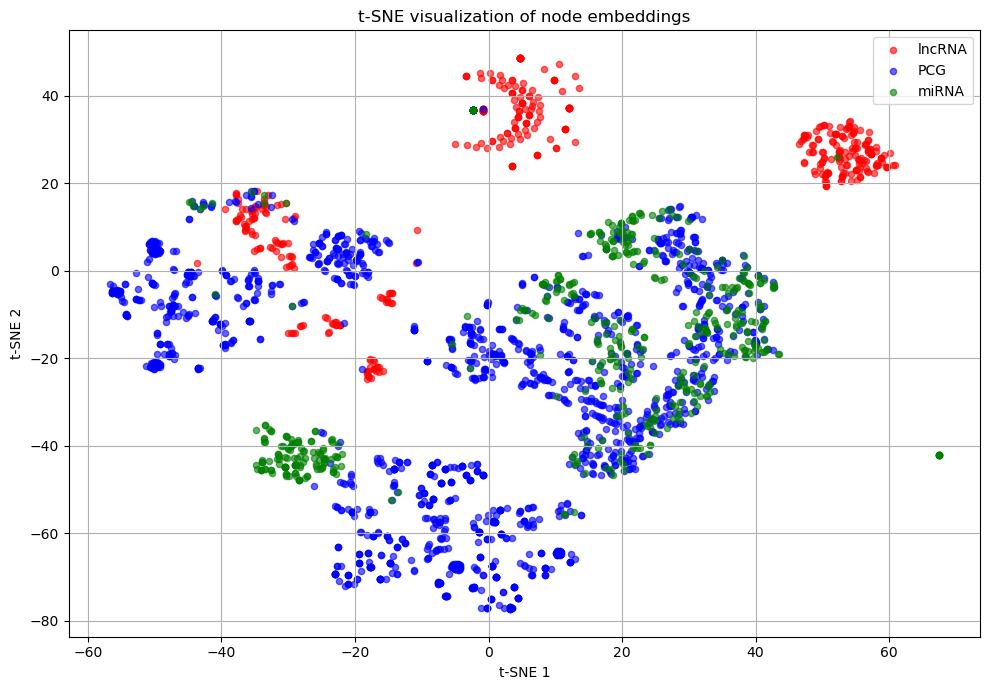

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


node_types_to_plot = ['lncRNA', 'PCG', 'miRNA']

all_embeddings = []
all_labels = []

for node_type in node_types_to_plot:
    emb = final_embeddings[node_type].cpu().detach().numpy()
    all_embeddings.append(emb)
    all_labels += [node_type] * emb.shape[0]

import numpy as np
all_embeddings = np.concatenate(all_embeddings, axis=0)

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 7))
colors = {'lncRNA': 'red', 'PCG': 'blue', 'miRNA': 'green'}

for node_type in node_types_to_plot:
    idx = [i for i, label in enumerate(all_labels) if label == node_type]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=node_type, alpha=0.6, s=20, c=colors[node_type])

plt.legend()
plt.title("t-SNE visualization of node embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


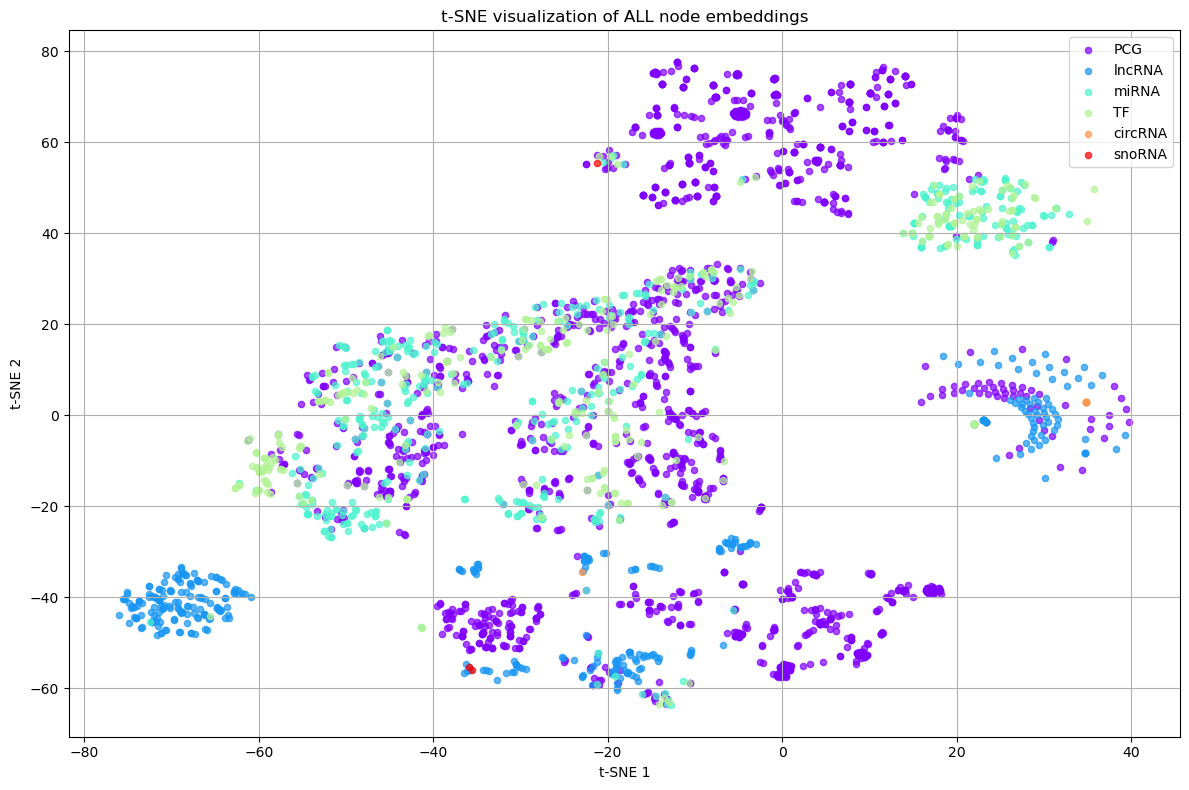

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# إعداد البيانات
all_embeddings = []
all_labels = []

for node_type, emb in final_embeddings.items():
    emb_np = emb.cpu().detach().numpy()
    all_embeddings.append(emb_np)
    all_labels += [node_type] * emb_np.shape[0]

# دمج كل الـ embeddings
all_embeddings = np.concatenate(all_embeddings, axis=0)

# تنفيذ t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings)

# رسم النتائج
plt.figure(figsize=(12, 8))

# ألوان تلقائية
import matplotlib.cm as cm
unique_types = list(final_embeddings.keys())
colors = cm.rainbow(np.linspace(0, 1, len(unique_types)))

for i, node_type in enumerate(unique_types):
    idx = [j for j, label in enumerate(all_labels) if label == node_type]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=node_type, color=colors[i], s=20, alpha=0.7)

plt.legend()
plt.title("t-SNE visualization of ALL node embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()
